<a href="https://colab.research.google.com/github/Shadhujan/Baseline_FER/blob/main/predictive_system_emotional_detaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opencv-python

In [24]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
import cv2


# 1) Rebuild your model architecture
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(48, 48, 3)
)

model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(7,   activation='softmax')
])

# 2) Compile (needed before loading weights / calling predict)
conv_base.trainable = True  # since you fine‑tuned
model.compile(
    optimizer=RMSprop(learning_rate=1e-5),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

# 3) Load the final fine‑tuned weights
model.load_weights(
    '/content/drive/MyDrive/checkpoints/'
    'emotion_weights_on_vgg16_cbtOn_epoch_60.weights.h5'
)

# 4) Label map for FER2013
label_map = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

def predict_emotion(image_path, show_image=True):
    # a) Load and convert to RGB
    img = Image.open(image_path).convert('RGB')
    open_cv_image = np.array(img)
    gray = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2GRAY)

    # b) Load Haar cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +
                                         'haarcascade_frontalface_default.xml')

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        raise ValueError("No face detected in the image.")

    # c) Crop the first detected face
    x, y, w, h = faces[0]
    face_img = open_cv_image[y:y+h, x:x+w]

    # d) Resize to (48, 48)
    face_img_pil = Image.fromarray(face_img).resize((48, 48), Image.LANCZOS)

    # e) Optionally show
    if show_image:
        plt.figure(figsize=(2,2))
        plt.imshow(face_img_pil)
        plt.axis('off')
        plt.title("Detected Face")
        plt.show()
    else:
        print("No face detected in the image.")

    # f) Preprocess for model
    x = np.asarray(face_img_pil, dtype='float32') / 255.0
    x = np.expand_dims(x, axis=0)  # (1, 48, 48, 3)

    # g) Predict
    preds = model.predict(x)
    idx   = np.argmax(preds[0])
    prob  = preds[0][idx]

    return label_map[idx], float(prob)



In [4]:
model.save('/content/drive/MyDrive/checkpoints/finetuning_on_pretrained_vgg16_finetuned.h5')

In [5]:
from google.colab import files
files.download('/content/drive/MyDrive/checkpoints/finetuning_on_pretrained_vgg16_finetuned.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.summary()

In [15]:
!ls '/content/drive/MyDrive/datasets/test/'

angry2.jpg  HappyKid.jpg  sadkid2.jpg  sadkid.jpg
angry.jpg   sad4.jpg	  sadkid3.jpg


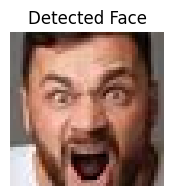

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted: Surprise (100.0%)


In [29]:
# Example usage:
label, confidence = predict_emotion('/content/drive/MyDrive/datasets/test/angry2.jpg')
print(f"Predicted: {label} ({confidence*100:.1f}%)")
